In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np

Data Creation

In [2]:
def DataCreation(data_size,start,end):
    input_data = []
    output_data = []
    input_size = torch.randint(start,end,(data_size,))
    for i in range(data_size):
        first_layer = torch.rand(input_size[i])
        x_0 = torch.randint(0,input_size[i],(1,))
        x_1 = torch.randint(1,input_size[i],(1,))
        if (x_1 == x_0):
            x_1 = x_1 - 1
        second_layer = torch.zeros(input_size[i])
        second_layer[x_0] = 1
        second_layer[x_1] = 1       
        input_data.append(torch.stack((first_layer,second_layer)))
        output_data.append(first_layer[x_0] + first_layer[x_1])
    return(input_data,output_data,data_size)

In [3]:
input_data,output_data,data_size = DataCreation(5000,2,10)
test_input,test_output,test_data_size = DataCreation(1000,2,14)

In [4]:
# print(input_data[:10])
# print(output_data[:10])

In [5]:
class Elmon(nn.Module):
    h = 3
    def __init__(self):
        super().__init__()
        self.h0 = torch.zeros(self.h,1,dtype = torch.float)
        self.U = nn.Parameter(torch.randn(self.h,2,requires_grad = True,dtype = torch.float))
        self.W = nn.Parameter(torch.randn(self.h,self.h,requires_grad = True,dtype = torch.float))
        self.V = nn.Parameter(torch.randn(1,self.h,requires_grad = True,dtype = torch.float))
        self.bias_x = nn.Parameter(torch.randn(self.h,1,requires_grad = True,dtype = torch.float))
        self.bias_y = nn.Parameter(torch.randn(1,1,requires_grad = True,dtype = torch.float))
        
    def forward(self,xi):
        ht = self.h0
        for i in range(len(xi[0])):
            ht = torch.tanh(self.U@xi[:,i].unsqueeze(1) + self.W@ht + self.bias_x) 
        ht = self.V@ht + self.bias_y
        return ht[0]
    

In [6]:
def train_loop(model, loss_fn, optimizer,data_size,input_data,output_data):
    loss_m = 0
    for i in range(data_size):
# Compute prediction
        X = input_data[i]
        y = output_data[i]
        pred = model(X)
# Calculating loss
        loss = loss_fn(pred, y)
# Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_m = loss_m + loss.detach()
    return loss_m/data_size

In [7]:
def test_loop(model,loss_fn,test_data_size,test_input,test_output):
    loss_t = 0
    for i in range(test_data_size):
        X = test_input[i]
        y = test_output[i]
        pred = model(X)
        loss = loss_fn(pred,y)
        loss_t = loss_t + loss.detach()
    return loss_t/test_data_size

Elman RNN

In [8]:
model_1 = Elmon()
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.005)
elmon_loss = torch.empty([1])
current_loss = 100
epochs = 0
while True:
    if (abs(current_loss) > 0.005 and epochs < 10) :
            current_loss = train_loop(model_1, loss_fn, optimizer,data_size,input_data,output_data)
            print("Epoch {}:{}".format(epochs+1,current_loss))
            elmon_loss = torch.cat((elmon_loss,torch.tensor([current_loss])))
            epochs = epochs + 1
    else:
        break
    
print("Done!")

Epoch 1:0.17095214128494263
Epoch 2:0.14376237988471985
Epoch 3:0.13556843996047974
Epoch 4:0.12702268362045288
Epoch 5:0.11581497639417648
Epoch 6:0.10993743687868118
Epoch 7:0.10685567557811737
Epoch 8:0.10121242702007294
Epoch 9:0.09242576360702515
Epoch 10:0.08072927594184875
Done!


In [9]:
elmon_test = test_loop(model_1,loss_fn,test_data_size,test_input,test_output)

In [10]:
# print(elmon_loss)

In [11]:
class LSTM(nn.Module):
    h = 5
    C = 5
    def __init__(self):
        
        super().__init__()
        
        self.h0 = torch.zeros(self.h,1,dtype = torch.float)
        self.C0 = torch.zeros(self.C,1,dtype = torch.float)
        
        self.Wf = nn.Parameter(torch.randn(self.C,self.h + 2,requires_grad = True,dtype = torch.float)/(np.sqrt(self.h+2)))
        self.bf = nn.Parameter(torch.zeros(self.C,1,requires_grad = True,dtype = torch.float))
        self.Wi = nn.Parameter(torch.randn(self.C,self.h + 2,requires_grad = True,dtype = torch.float)/(np.sqrt(self.h+2)))
        self.bi = nn.Parameter(torch.zeros(self.C,1,requires_grad = True,dtype = torch.float))
        self.WC = nn.Parameter(torch.randn(self.C,self.h + 2,requires_grad = True,dtype = torch.float)/(np.sqrt(self.h+2)))
        self.bC = nn.Parameter(torch.zeros(self.C,1,requires_grad = True,dtype = torch.float))
        self.Wo = nn.Parameter(torch.randn(self.C,self.h + 2,requires_grad = True,dtype = torch.float)/(np.sqrt(self.h+2)))
        self.bo = nn.Parameter(torch.zeros(self.C,1,requires_grad = True,dtype = torch.float))
        self.Wy = nn.Parameter(torch.randn(1,self.h,requires_grad = True,dtype = torch.float)/(np.sqrt(self.h)))
        self.by = nn.Parameter(torch.zeros(1,1,requires_grad = True,dtype = torch.float))
        
    def forward(self,xt):
        ht = self.h0
        Ct = self.C0
        for i in range(len(xt)):
            cathx = torch.cat((ht,xt[:,i].unsqueeze(1)))
            ft = torch.sigmoid(self.Wf@(cathx) + self.bf)
            it = torch.sigmoid(self.Wi@(cathx) + self.bi)
            C_t = torch.tanh(self.WC@(cathx) + self.bC)
            Ct = (ft*Ct) + (it*C_t)
            ot = torch.sigmoid(self.Wo@(cathx) + self.bo)
            ht = (ot*torch.tanh(Ct))
        y = self.Wy@ht + self.by
        
        return y[0]

In [12]:
model_2 = LSTM()
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.015)
LSTM_loss = torch.empty([1])
current_loss = 100
epochs = 0
while True:
    if (
#         abs(current_loss) > 0.05 and 
        epochs < 10) :
            current_loss = train_loop(model_2, loss_fn, optimizer,data_size,input_data,output_data)
            print("Epoch {}:{}".format(epochs+1,current_loss))
            LSTM_loss = torch.cat((LSTM_loss,torch.tensor([current_loss])))
            epochs = epochs + 1
    else:
        break
print("Done!")

Epoch 1:0.13855396211147308
Epoch 2:0.11508720368146896
Epoch 3:0.10973673313856125
Epoch 4:0.10680483281612396
Epoch 5:0.10494488477706909
Epoch 6:0.10380426049232483
Epoch 7:0.10307390242815018
Epoch 8:0.10257349908351898
Epoch 9:0.10220884531736374
Epoch 10:0.10193004459142685
Done!


In [13]:
LSTM_test = test_loop(model_2,loss_fn,test_data_size,test_input,test_output)

In [14]:
class GRU(nn.Module):
    h = 5
    def __init__(self):
        
        super().__init__()
        self.h0 = torch.zeros(self.h,1,dtype = torch.float)
        self.Wr = nn.Parameter(torch.randn(self.h,self.h + 2,dtype = torch.float)/(np.sqrt(self.h+2)))
        self.br = nn.Parameter(torch.rand(self.h,1,dtype = torch.float))
        self.Wz = nn.Parameter(torch.randn(self.h,self.h + 2,dtype = torch.float)/(np.sqrt(self.h+2)))
        self.bz = nn.Parameter(torch.rand(self.h,1,dtype = torch.float))
        self.W = nn.Parameter(torch.randn(self.h,self.h + 2,dtype = torch.float)/(np.sqrt(self.h+2)))
        self.b = nn.Parameter(torch.rand(self.h,1,dtype = torch.float))
        self.Wy = nn.Parameter(torch.randn(1,self.h,dtype = torch.float)/(np.sqrt(self.h)))
        self.by = nn.Parameter(torch.rand(1,1,dtype = torch.float))
        
    def forward(self,xt):
        
        ht = self.h0
        for i in range(len(xt)):
            
            cathx = torch.cat((ht,xt[:,i].unsqueeze(1)))
            
            zt = torch.sigmoid(self.Wz@(cathx) + self.bz)
      
            rt = torch.sigmoid(self.Wr@(cathx) + self.br)
            
            h_t = torch.tanh(self.W@(torch.cat((torch.mul(rt,ht),xt[:,i].unsqueeze(1)))) + self.b)
            
            ht = torch.mul(1-zt,ht) + torch.mul(zt,h_t)
            
        y = self.Wy@ht + self.by
        return y[0]

In [15]:
model_3 = GRU()
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.015)
GRU_loss = torch.empty([1])
current_loss = 100
epochs = 0

while True:
    if (abs(current_loss) > 0.05 and epochs < 10) :
            current_loss = train_loop(model_3, loss_fn, optimizer,data_size,input_data,output_data)
            print("Epoch {}:{}".format(epochs+1,current_loss))
            GRU_loss = torch.cat((GRU_loss,torch.tensor([current_loss])))
            epochs = epochs + 1
    else:
        break
print("Done!")

Epoch 1:0.14417299628257751
Epoch 2:0.11585243046283722
Epoch 3:0.10526351630687714
Epoch 4:0.10403251647949219
Epoch 5:0.10342343896627426
Epoch 6:0.10300768911838531
Epoch 7:0.10270010679960251
Epoch 8:0.10246028006076813
Epoch 9:0.10226529836654663
Epoch 10:0.10210207104682922
Done!


In [16]:
GRU_test = test_loop(model_3,loss_fn,test_data_size,test_input,test_output)

In [17]:
loss_m = 0
loss_fn = nn.MSELoss()
for i in range(data_size):
    x = torch.tensor([1])
    y = output_data[i]
    loss = loss_fn(x, y)
    loss_m = loss_m + loss
loss_m = loss_m/data_size    
print(loss_m)

tensor(0.1669)


In [18]:
testloss_m = 0
loss_fn = nn.MSELoss()
for i in range(test_data_size):
    x = torch.tensor([1])
    y = test_output[i]
    loss = loss_fn(x, y)
    testloss_m = testloss_m + loss
testloss_m = testloss_m/test_data_size    
print(testloss_m)

tensor(0.1645)


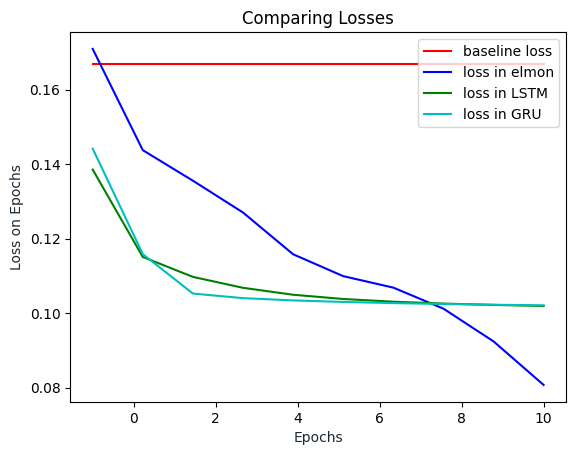

In [19]:
x = torch.linspace(-1,10,10)
y = torch.ones(10)*loss_m
plt.plot(x, y, '-r', label ="baseline loss")
plt.plot(x,elmon_loss[1:11],'-b',label = "loss in elmon")
plt.plot(x,LSTM_loss[1:11],'-g',label = "loss in LSTM")
plt.plot(x,GRU_loss[1:11],'-c',label = "loss in GRU")
plt.title('Comparing Losses')
plt.xlabel('Epochs', color='#1C2833')
plt.ylabel('Loss on Epochs', color='#1C2833')
plt.legend(loc='upper right')
plt.show()

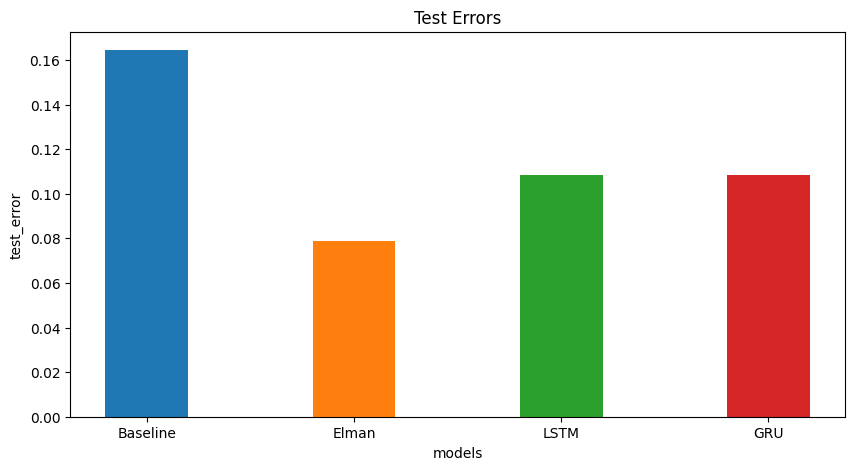

In [20]:
Loss = {'Baseline':testloss_m, 'Elman':elmon_test, 'LSTM':LSTM_test,
    'GRU':GRU_test}
modelLoss = list(Loss.keys())
lossValues = list(Loss.values())
fig = plt.figure(figsize = (10, 5))
plt.bar(modelLoss[0], lossValues[0],width = 0.4)

plt.bar(modelLoss[1], lossValues[1], width = 0.4)

plt.bar(modelLoss[2], lossValues[2],width = 0.4)

plt.bar(modelLoss[3], lossValues[3], width = 0.4)

plt.xlabel("models")
plt.ylabel("test_error")
plt.title("Test Errors")
plt.show()